
# Projeto: Análise de Desempenho em Provas de Python com IA

**Disciplina:** Modelagem e estatistica  
**Autor:** _Deivison Ryan Brito Tavares & Carlos Eduardo Ferreira Texeira_  
**Dataset:** Python Learning & Exam Performance Dataset (Kaggle)  

---

## 1. Introdução e Objetivos

Este projeto tem como objetivo colocar em prática as seguintes habilidades:

1. **Análise exploratória de dados (EDA)** com limpeza, tratamento de valores ausentes e investigação das relações entre variáveis independentes e dependentes;
2. **Implementação e comparação** de algoritmos de IA para:
   - Regressão: regressão linear simples, múltipla e polinomial;
   - Classificação: Naive Bayes e Regressão Logística;
3. **Avaliação de desempenho** com métricas apropriadas para regressão e classificação;
4. **Otimização de modelos** usando validação cruzada e *tuning* de hiperparâmetros (PyCaret e `sklearn`), discutindo ganhos e limitações.

Ferramentas obrigatórias utilizadas neste notebook:

- `pandas`
- `seaborn`
- `statsmodels`
- `scikit-learn`
- `pycaret`

### 1.1. Problema de negócio

O conjunto de dados contém informações sobre **estudantes aprendendo Python**
(idade, país, experiência prévia, hábitos de estudo, participação em fóruns, etc.)
e seus **resultados em uma prova final**.

Definiremos dois problemas de modelagem:

- **Regressão:** prever a **nota da prova final** (`final_exam_score`);
- **Classificação:** prever se o estudante **foi aprovado** na prova (`passed_exam`).

### 1.2. Hipóteses de negócio

Algumas hipóteses que iremos investigar:

1. Estudantes que **resolvem mais exercícios práticos** e **fazem mais projetos** tendem a obter **notas mais altas**.
2. Participar de **fóruns de discussão** e usar **Kaggle** está associado a melhor desempenho.
3. Estudantes com **maior experiência prévia em programação** atingem melhores resultados no exame de Python.



### Guia Rápido do Notebook

- Objetivo: prever a nota final (`final_exam_score`) e predizer aprovação (`passed_exam`).
- Fluxo: Carregar dados → EDA (gráficos + testes) → Preparação → Modelagem → Otimização → Avaliação final.
- Dica: execute células em ordem; mantenha `random_state=42` para reprodutibilidade.


In [ ]:
!pip install pandas numpy seaborn matplotlib statsmodels scikit-learn pycaret jupyter scipy

In [ ]:
!pip install --upgrade numpy pandas pycaret

  Using cached numpy-2.3.5-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.3.3-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)


In [ ]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB

from scipy import stats

# PyCaret
from pycaret.regression import (
    setup as reg_setup,
    compare_models as reg_compare,
    tune_model as reg_tune,
    pull as reg_pull
)
from pycaret.classification import (
    setup as cls_setup,
    compare_models as cls_compare,
    tune_model as cls_tune,
    pull as cls_pull
)

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", palette="muted", font_scale=1.0)
plt.rcParams["figure.figsize"] = (8, 5)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 2. Dados: Fonte, Licença e Carregamento

- **Nome:** Python Learning & Exam Performance Dataset  
- **Autor:** Emon Sarkar  
- **Plataforma:** Kaggle  
- **Link:** https://www.kaggle.com/datasets/emonsharkar/python-learning-and-exam-performance-dataset  

> Consulte a licença na página do dataset (seção *License*) antes de uso público.

Coloque o arquivo CSV em `data/python_learning_exam_performance.csv` ou na raiz do projeto.


In [ ]:

# Carregamento do CSV
possible_paths = [
    "data/python_learning_exam_performance.csv",
    "python_learning_exam_performance.csv",
]

df = None
for p in possible_paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"Arquivo carregado de: {p}")
        break

if df is None:
    raise FileNotFoundError(
        "Não foi possível encontrar 'python_learning_exam_performance.csv'. "
        "Coloque o arquivo na raiz do projeto ou em 'data/'."
    )

df.head()


Arquivo carregado de: python_learning_exam_performance.csv


,student_id,age,country,prior_programming_experience,weeks_in_course,hours_spent_learning_per_week,practice_problems_solved,projects_completed,tutorial_videos_watched,uses_kaggle,participates_in_discussion_forums,debugging_sessions_per_week,self_reported_confidence_python,final_exam_score,passed_exam
0,1,54,Pakistan,Beginner,12,12.2,60,1,24,0,1,4,10,53.8,0
1,2,44,Nigeria,NaN,15,14.2,52,1,32,0,0,5,7,31.9,0
2,3,30,India,Intermediate,5,7.7,71,1,43,0,0,6,3,59.4,0
3,4,23,Nigeria,Beginner,4,5.6,64,2,40,1,0,3,10,58.8,0
4,5,36,UK,NaN,3,3.5,62,1,47,1,0,3,7,24.8,0


In [ ]:

# Teste simples de schema
expected_columns = {
    "student_id", "age", "country", "prior_programming_experience",
    "weeks_in_course", "hours_spent_learning_per_week",
    "practice_problems_solved", "projects_completed",
    "tutorial_videos_watched", "uses_kaggle",
    "participates_in_discussion_forums", "debugging_sessions_per_week",
    "self_reported_confidence_python", "final_exam_score", "passed_exam"
}

missing_cols = expected_columns.difference(df.columns)
extra_cols = set(df.columns).difference(expected_columns)

print("Colunas faltantes:", missing_cols)
print("Colunas extras:", extra_cols)

assert len(missing_cols) == 0, "O dataset não contém todas as colunas esperadas."
print("✅ Teste de schema básico passou.")


Colunas faltantes: set()
Colunas extras: set()
✅ Teste de schema básico passou.


### Resumo (EDA)

- Checar schema, tipos e valores ausentes.
- Visualizar distribuições, relações e outliers (histogramas, boxplots, pairplot).
- Testes: correlação, ANOVA, qui-quadrado para insights estatísticos.


## 3. EDA — Análise Exploratória de Dados

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   student_id                         3000 non-null   int64  
 1   age                                3000 non-null   int64  
 2   country                            3000 non-null   object 
 3   prior_programming_experience       1938 non-null   object 
 4   weeks_in_course                    3000 non-null   int64  
 5   hours_spent_learning_per_week      3000 non-null   float64
 6   practice_problems_solved           3000 non-null   int64  
 7   projects_completed                 3000 non-null   int64  
 8   tutorial_videos_watched            3000 non-null   int64  
 9   uses_kaggle                        3000 non-null   int64  
 10  participates_in_discussion_forums  3000 non-null   int64  
 11  debugging_sessions_per_week        3000 non-null   int64

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
student_id,3000.0,NaN,NaN,NaN,1500.5,866.169729,1.0,750.75,1500.5,2250.25,3000.0
age,3000.0,NaN,NaN,NaN,35.327,11.302182,16.0,26.0,36.0,45.0,54.0
country,3000,10,Brazil,339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prior_programming_experience,1938,3,Beginner,1034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weeks_in_course,3000.0,NaN,NaN,NaN,8.121,4.275019,1.0,5.0,8.0,12.0,15.0
hours_spent_learning_per_week,3000.0,NaN,NaN,NaN,7.035267,2.936134,0.0,5.0,7.0,9.0,17.1
practice_problems_solved,3000.0,NaN,NaN,NaN,59.983667,7.713056,35.0,55.0,60.0,65.0,87.0
projects_completed,3000.0,NaN,NaN,NaN,2.001333,1.395701,0.0,1.0,2.0,3.0,9.0
tutorial_videos_watched,3000.0,NaN,NaN,NaN,39.896667,6.263258,19.0,35.0,40.0,44.0,63.0
uses_kaggle,3000.0,NaN,NaN,NaN,0.400667,0.490115,0.0,0.0,0.0,1.0,1.0


In [ ]:

# Valores ausentes
df.isna().sum()


,0
student_id,0
age,0
country,0
prior_programming_experience,1062
weeks_in_course,0
hours_spent_learning_per_week,0
practice_problems_solved,0
projects_completed,0
tutorial_videos_watched,0
uses_kaggle,0


In [ ]:

# Tratamento simples de ausentes
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

for col in num_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

df.isna().sum()


,0
student_id,0
age,0
country,0
prior_programming_experience,0
weeks_in_course,0
hours_spent_learning_per_week,0
practice_problems_solved,0
projects_completed,0
tutorial_videos_watched,0
uses_kaggle,0


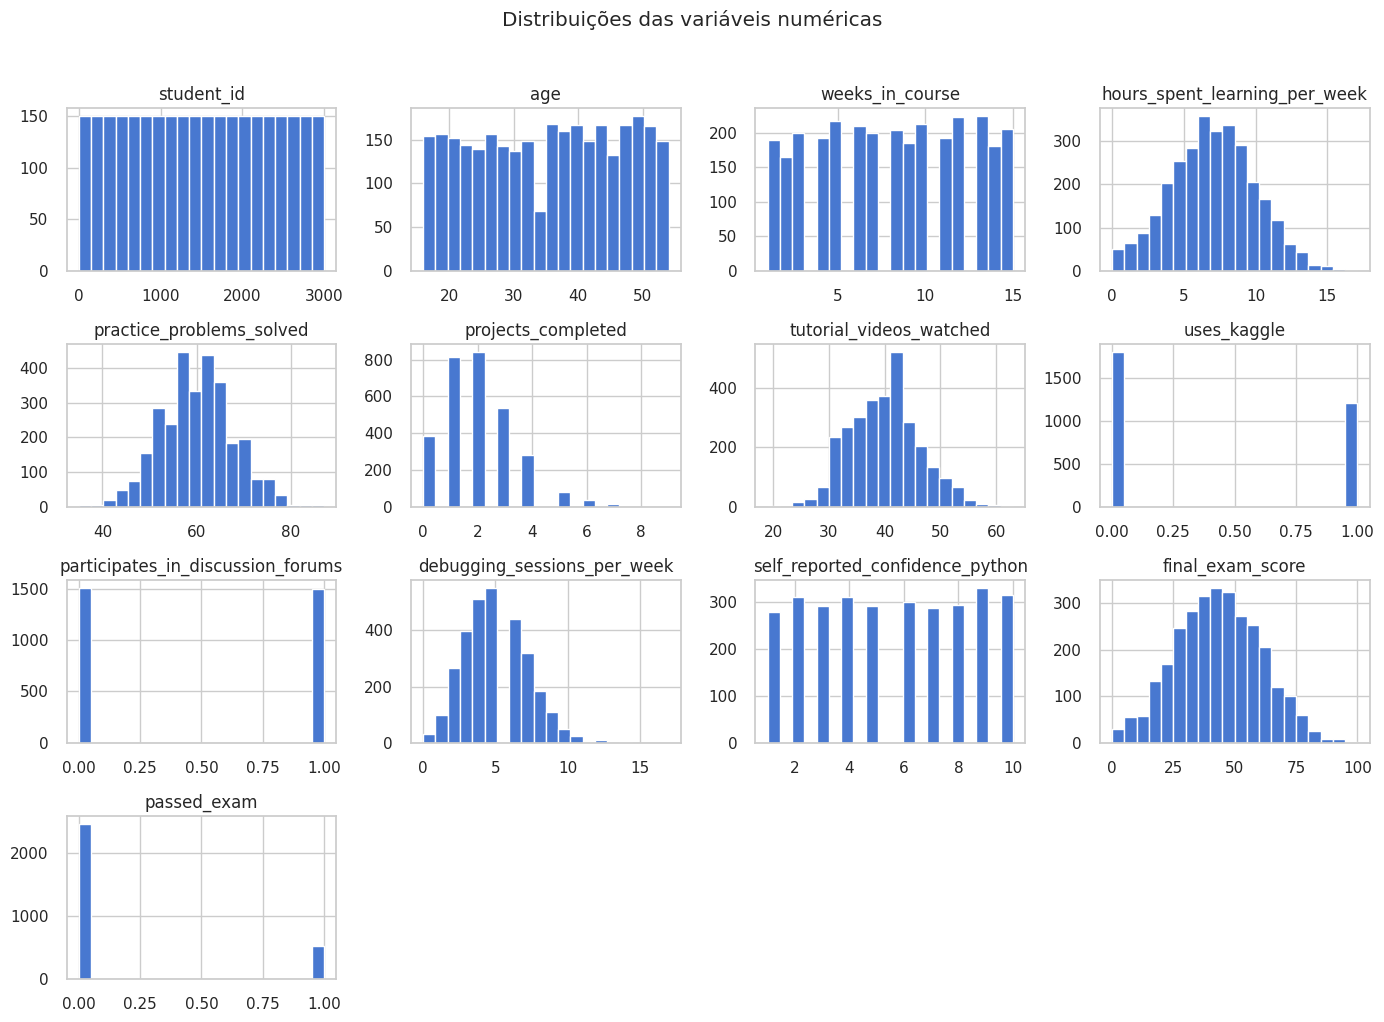

In [ ]:

# Histogramas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

df[numeric_cols].hist(figsize=(14, 10), bins=20)
plt.suptitle("Distribuições das variáveis numéricas", y=1.02)
plt.tight_layout()
plt.show()


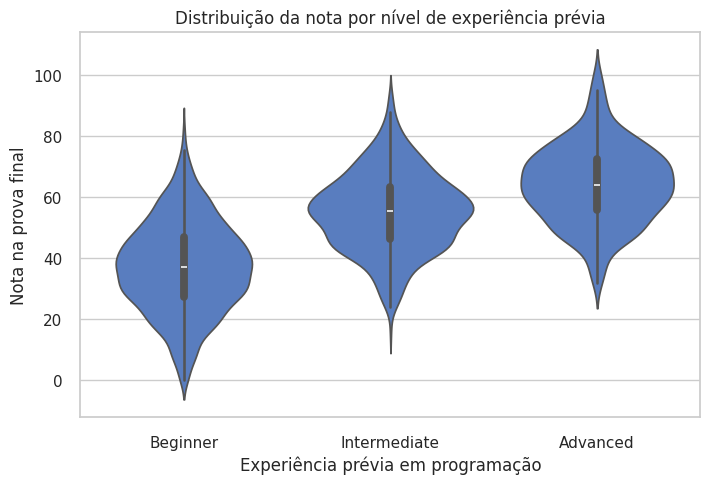

In [ ]:
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df,
    x="prior_programming_experience",
    y="final_exam_score",
    inner="box"
)
plt.title("Distribuição da nota por nível de experiência prévia")
plt.xlabel("Experiência prévia em programação")
plt.ylabel("Nota na prova final")
plt.show()


Observa-se que estudantes com experiência intermediária ou avançada apresentam distribuições de notas mais elevadas e menos dispersas, sugerindo maior consistência no aprendizado. Já os iniciantes têm maior variabilidade e tendência a notas mais baixas, o que indica que a falta de base prévia pode dificultar o acompanhamento do curso. Esse comportamento reforça o resultado do teste ANOVA, que indicou diferença estatisticamente significativa entre os grupos.

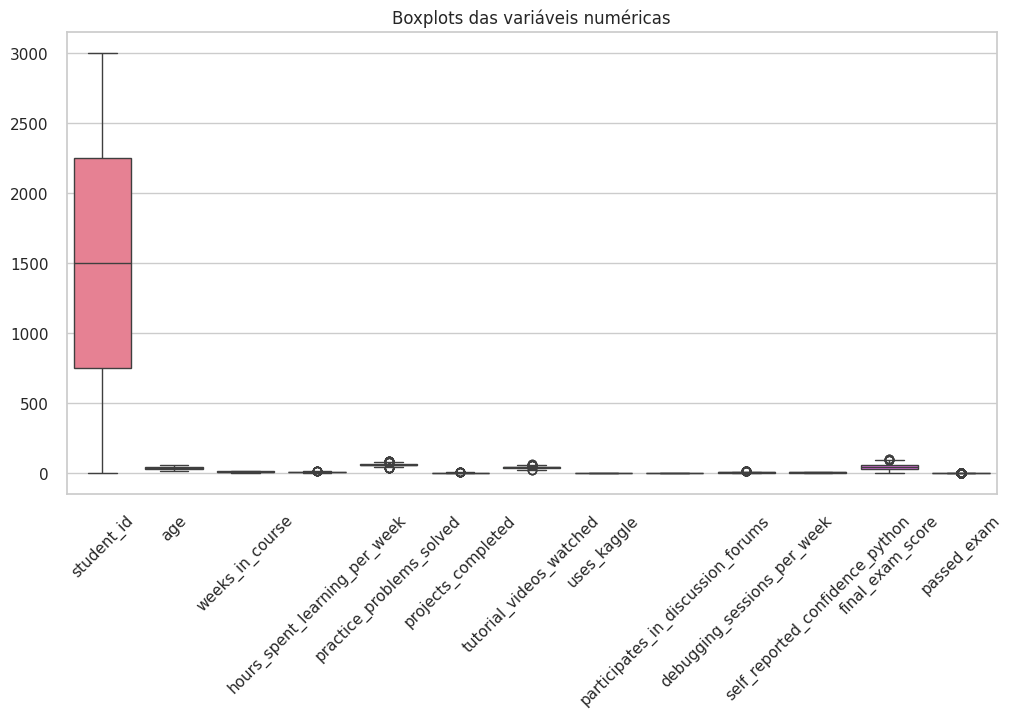

In [ ]:
numeric_without_id = [col for col in numeric_cols if col != "student_id"]

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_without_id])
plt.xticks(rotation=45)
plt.title("Boxplots das variáveis numéricas")
plt.show()


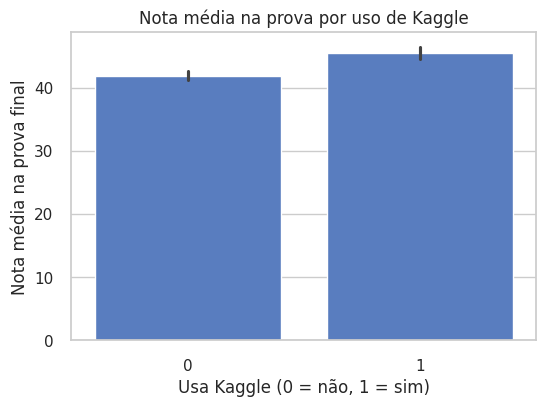

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df,
    x="uses_kaggle",
    y="final_exam_score",
    estimator=np.mean,
    ci=95
)
plt.title("Nota média na prova por uso de Kaggle")
plt.xlabel("Usa Kaggle (0 = não, 1 = sim)")
plt.ylabel("Nota média na prova final")
plt.show()


Estudantes que utilizam o Kaggle obtêm, em média, notas superiores. Isso sugere que a prática por meio de desafios, kernels e competições contribui para consolidar conceitos e melhorar o desempenho no exame final. Embora não prove causalidade, a diferença consistente indica que o engajamento em plataformas externas de prática pode ser um fator relevante para o aprendizado.

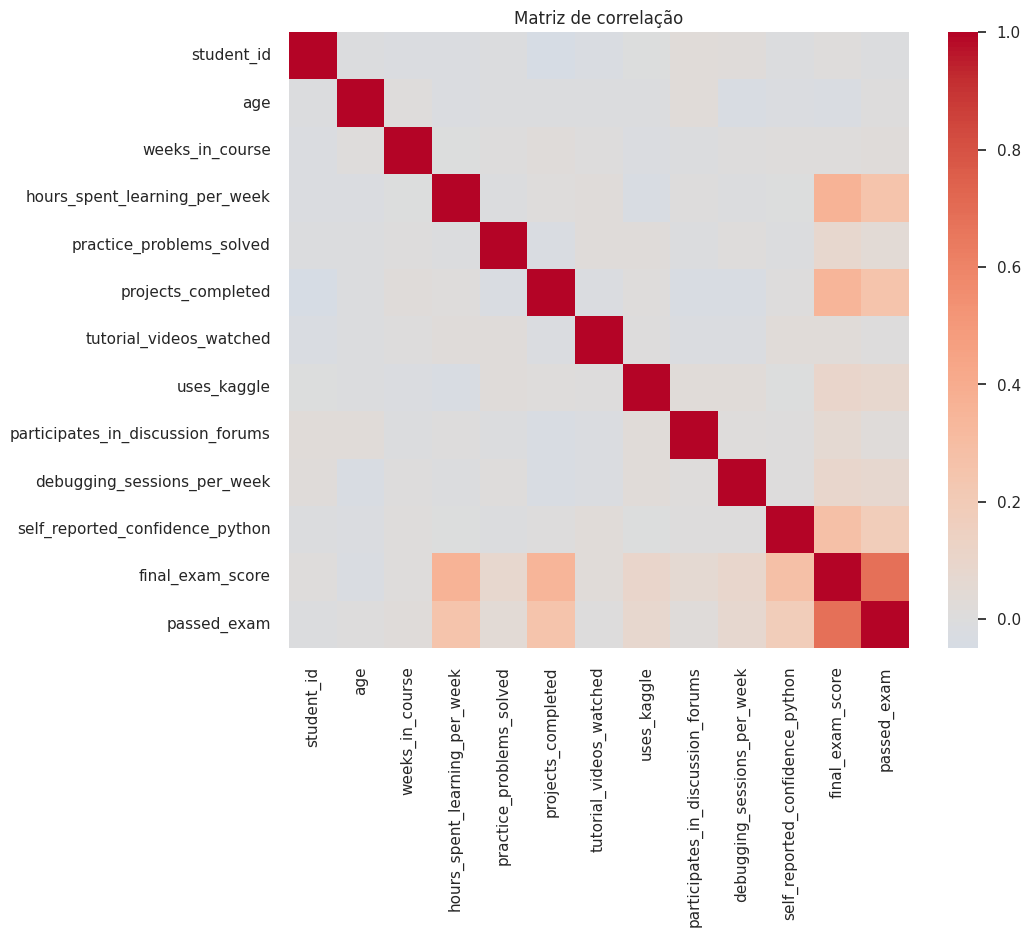

In [ ]:

# Heatmap de correlação
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matriz de correlação")
plt.show()


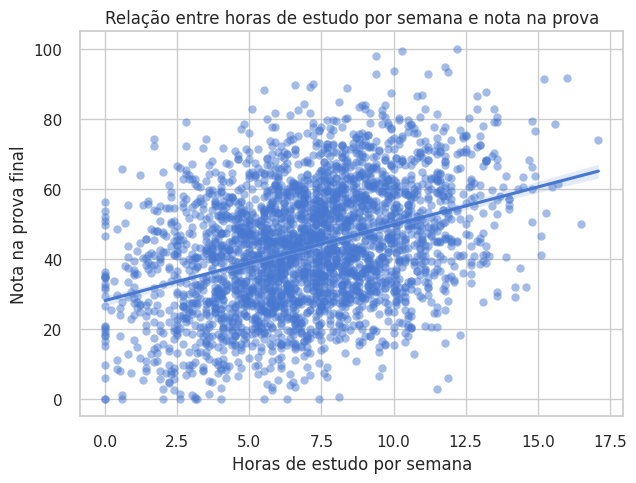

In [ ]:
plt.figure(figsize=(7, 5))
sns.regplot(
    data=df,
    x="hours_spent_learning_per_week",
    y="final_exam_score",
    scatter_kws={"alpha": 0.5}
)
plt.title("Relação entre horas de estudo por semana e nota na prova")
plt.xlabel("Horas de estudo por semana")
plt.ylabel("Nota na prova final")
plt.show()


Existe uma relação positiva clara entre horas semanais de estudo e nota final. A linha de tendência indica que o desempenho aumenta conforme o aluno dedica mais tempo à prática e ao estudo dirigido. Esse comportamento justifica o uso de regressão linear simples nessa variável, que apresenta relação aproximadamente linear e significativa com o score final.

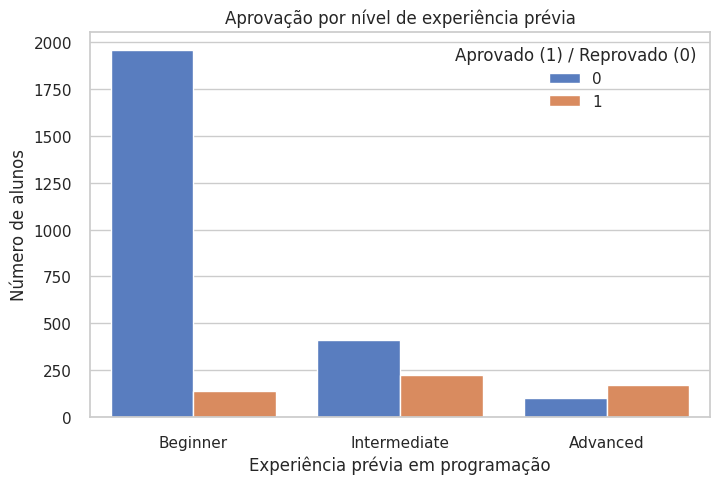

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df,
    x="prior_programming_experience",
    hue="passed_exam"
)
plt.title("Aprovação por nível de experiência prévia")
plt.xlabel("Experiência prévia em programação")
plt.ylabel("Número de alunos")
plt.legend(title="Aprovado (1) / Reprovado (0)")
plt.show()


A taxa de aprovação é visivelmente maior entre estudantes com experiência intermediária e avançada. O grupo iniciante concentra a maior parte das reprovações, reforçando a hipótese de que a base técnica prévia influencia de forma relevante a probabilidade de sucesso no curso. Esse padrão também sugere que políticas de nivelamento ou módulos preparatórios podem reduzir desigualdades de desempenho.

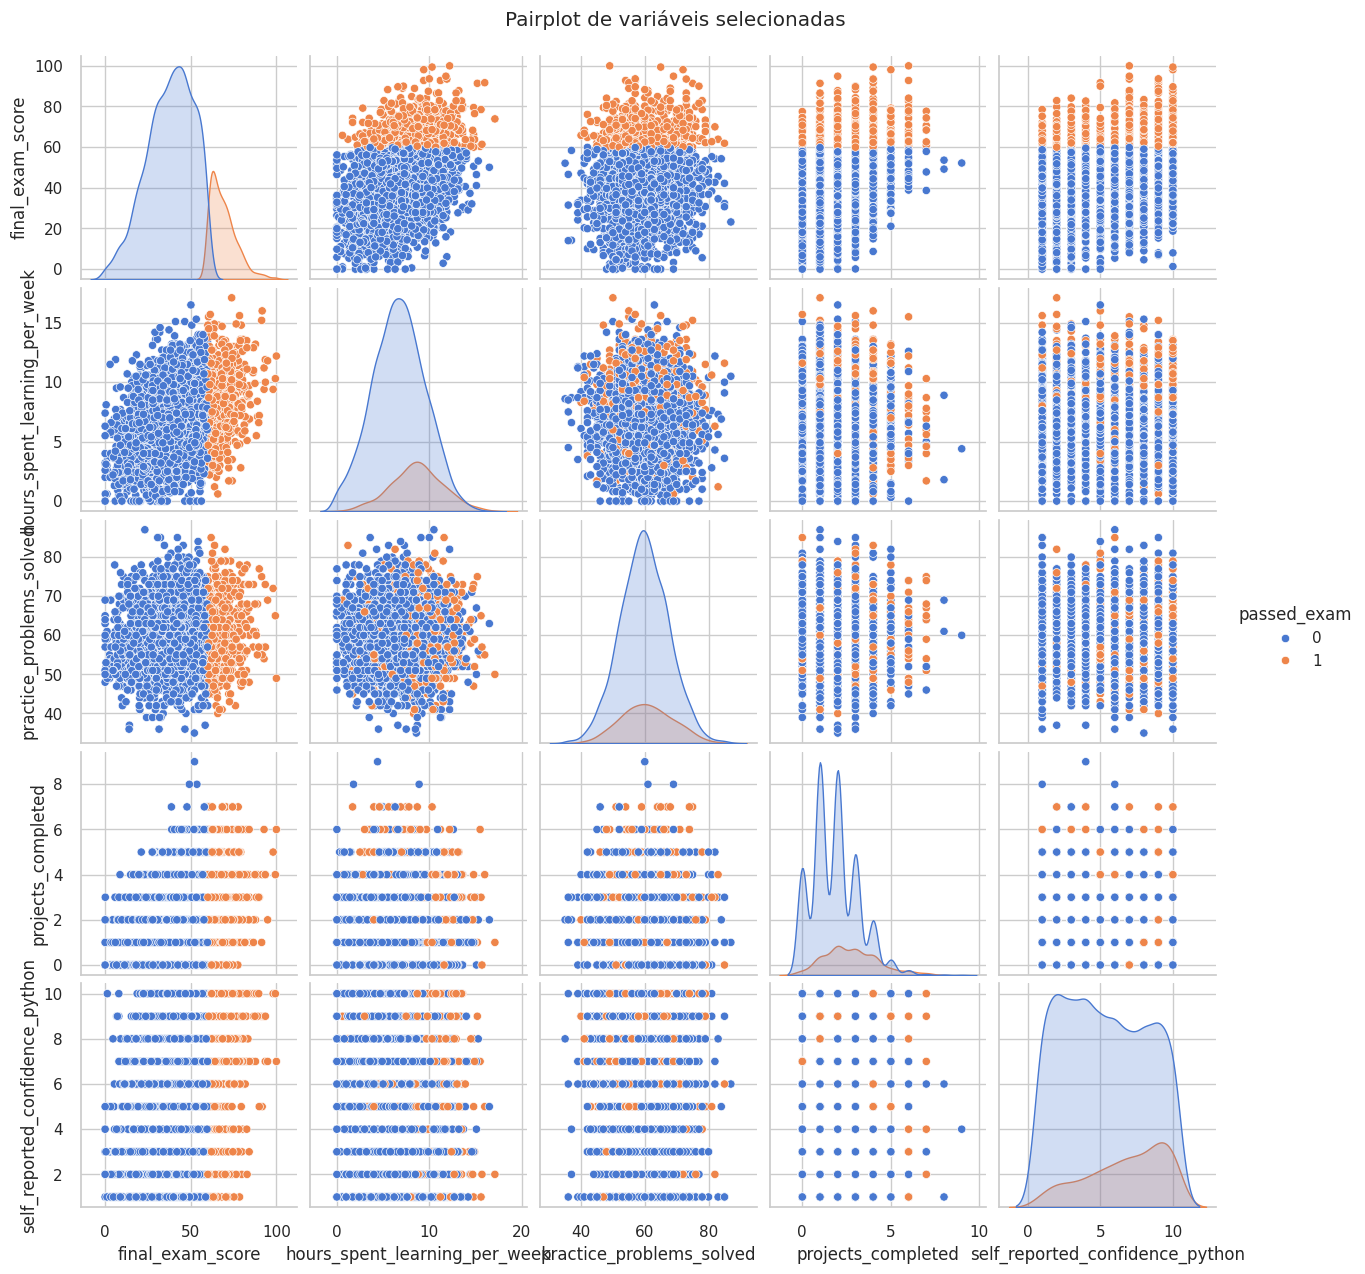

In [ ]:

# Pairplot
subset_cols = [
    "final_exam_score",
    "passed_exam",
    "hours_spent_learning_per_week",
    "practice_problems_solved",
    "projects_completed",
    "self_reported_confidence_python"
]

sns.pairplot(df[subset_cols], hue="passed_exam", diag_kind="kde")
plt.suptitle("Pairplot de variáveis selecionadas", y=1.02)
plt.show()


In [ ]:

# Testes estatísticos
pearson_r, pearson_p = stats.pearsonr(
    df["hours_spent_learning_per_week"],
    df["final_exam_score"]
)
print(f"Correlação de Pearson (horas x nota): r={pearson_r:.3f}, p-valor={pearson_p:.3e}")

groups = [
    g["final_exam_score"].values
    for _, g in df.groupby("prior_programming_experience")
]
anova_F, anova_p = stats.f_oneway(*groups)
print(f"ANOVA (nota ~ experiência prévia): F={anova_F:.3f}, p-valor={anova_p:.3e}")

contingency = pd.crosstab(df["uses_kaggle"], df["passed_exam"])
chi2, chi_p, dof, expected = stats.chi2_contingency(contingency)
print("Qui-quadrado (uses_kaggle x passed_exam):")
print(f"chi2={chi2:.3f}, dof={dof}, p-valor={chi_p:.3e}")
contingency


Correlação de Pearson (horas x nota): r=0.365, p-valor=2.286e-95
ANOVA (nota ~ experiência prévia): F=698.959, p-valor=7.135e-250
Qui-quadrado (uses_kaggle x passed_exam):
chi2=17.877, dof=1, p-valor=2.356e-05


passed_exam,0,1
uses_kaggle,,
0,1523,275
1,945,257


A análise mostra que há uma correlação positiva moderada entre horas de estudo e nota final, indicando que estudar mais tende a melhorar o desempenho; além disso, a ANOVA revela diferenças muito significativas nas notas entre alunos com e sem experiência prévia em programação, sugerindo que essa experiência impacta fortemente o resultado; por fim, o teste qui-quadrado indica associação estatisticamente relevante entre usar Kaggle e passar na prova, embora o efeito pareça mais fraco do que o impacto da experiência prévia.

In [ ]:

# Outliers via IQR
q1 = df["final_exam_score"].quantile(0.25)
q3 = df["final_exam_score"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["final_exam_score"] < lower_bound) | (df["final_exam_score"] > upper_bound)]
print(f"Número de possíveis outliers em 'final_exam_score': {len(outliers)}")


Número de possíveis outliers em 'final_exam_score': 8


### Resumo (Preparação)

- One-hot para categóricas e remoção de IDs.
- Definir `target` para regressão e classificação.
- Dividir em `train/val/test` e criar baselines.


## 4. Preparação para Modelagem

Pré-processamento: A coluna student_id foi removida, e as variáveis categóricas (country, prior_programming_experience) foram convertidas usando One-Hot Encoding.



Nesta etapa, os dados foram preparados para uso em modelos de aprendizado de máquina. A coluna `student_id` foi removida por não possuir valor analítico, e as variáveis categóricas foram transformadas em numéricas por meio de *One-Hot Encoding*, garantindo compatibilidade com os algoritmos.

Foram definidos dois tipos de variáveis alvo: uma contínua (`final_exam_score`) para problemas de regressão e uma binária (`passed_exam`) para problemas de classificação. Em seguida, os dados foram separados em variáveis explicativas (X) e variáveis resposta (y).

O conjunto de dados foi dividido em três partes: treino, validação e teste. O conjunto de treino contém 1470 amostras, o de validação 630 e o de teste 900, todos com 21 variáveis. Essa divisão permite treinar os modelos, ajustá-los adequadamente e avaliá-los de forma justa em dados não vistos.


In [ ]:

# One-hot e splits
df_model = df.drop(columns=["student_id"])
df_model = pd.get_dummies(df_model, drop_first=True)

target_reg = "final_exam_score"
target_cls = "passed_exam"

X = df_model.drop(columns=[target_reg, target_cls])
y_reg = df_model[target_reg]
y_cls = df_model[target_cls]

X_temp, X_test, y_reg_temp, y_reg_test, y_cls_temp, y_cls_test = train_test_split(
    X, y_reg, y_cls, test_size=0.3, random_state=42
)

X_train, X_val, y_reg_train, y_reg_val, y_cls_train, y_cls_val = train_test_split(
    X_temp, y_reg_temp, y_cls_temp, test_size=0.3, random_state=42
)

X_train.shape, X_val.shape, X_test.shape


((1470, 21), (630, 21), (900, 21))

Foi criado um modelo baseline que utiliza a **média da nota final do conjunto de treino** como previsão para todos os alunos do conjunto de validação. Esse modelo simples serve como referência mínima de desempenho.

Os resultados obtidos (MAE = 14.016, RMSE = 17.580 e R² ≈ 0) indicam que o baseline praticamente não explica a variabilidade dos dados. Assim, qualquer modelo mais elaborado que supere essas métricas pode ser considerado efetivamente melhor que uma previsão ingênua.

In [ ]:

# Baseline Regressão
y_reg_mean = y_reg_train.mean()
y_reg_pred_baseline_val = np.repeat(y_reg_mean, len(y_reg_val))

baseline_reg_mae = mean_absolute_error(y_reg_val, y_reg_pred_baseline_val)
baseline_reg_rmse = mean_squared_error(y_reg_val, y_reg_pred_baseline_val, squared=False)
baseline_reg_r2 = r2_score(y_reg_val, y_reg_pred_baseline_val)

print("Baseline regressão (média do treino):")
print(f"MAE  = {baseline_reg_mae:.3f}")
print(f"RMSE = {baseline_reg_rmse:.3f}")
print(f"R^2  = {baseline_reg_r2:.3f}")


Baseline regressão (média do treino):
MAE  = 14.016
RMSE = 17.580
R^2  = -0.000


Regressão: A baseline (média do treino) resultou em MAE = 14.016, RMSE = 17.580, R² = -0.000.

In [ ]:

# Baseline Classificação
majority_class = y_cls_train.mode()[0]
y_cls_pred_baseline_val = np.repeat(majority_class, len(y_cls_val))

baseline_cls_acc = accuracy_score(y_cls_val, y_cls_pred_baseline_val)
print("Baseline classificação (classe majoritária):")
print(f"Acurácia = {baseline_cls_acc:.3f}")
print(f"Classe majoritária (treino) = {majority_class}")


Baseline classificação (classe majoritária):
Acurácia = 0.817
Classe majoritária (treino) = 0


Classificação: A baseline (classe majoritária, que é 0 - reprovado) atingiu uma Acurácia = 0.817.

### Resumo (Modelagem)

- Statsmodels para interpretação (coeficientes, p-valores).
- Sklearn pipelines para regressão linear, polinomial e classificação.
- Modelos: Linear, Polinomial, Naive Bayes, Regressão Logística.


## 5. Modelagem de Regressão

## Regressão Linear – Resultados (Resumo)

Inicialmente, foi ajustado um modelo de **regressão linear simples**, utilizando apenas a variável `hours_spent_learning_per_week`. O modelo apresentou R² = 0.133, indicando que o tempo semanal de estudo explica cerca de 13% da variação na nota final. O coeficiente positivo e estatisticamente significativo confirma que mais horas de estudo estão associadas a melhores notas, embora o poder explicativo seja limitado.

Em seguida, foi ajustado um modelo de **regressão linear múltipla**, incorporando variáveis demográficas, comportamentais, acadêmicas e dummies de país e experiência prévia. Esse modelo apresentou R² = 0.661, demonstrando um ganho substancial de explicação da variabilidade da nota final.

Os resultados indicam que fatores como horas de estudo, projetos concluídos, problemas resolvidos, sessões de depuração e autoconfiança em Python têm impacto positivo significativo no desempenho. Já a experiência prévia em programação mostrou forte efeito negativo em relação à categoria de referência, indicando diferenças relevantes entre perfis de estudantes. Apesar do bom ajuste, o modelo apresenta indícios de multicolinearidade, o que deve ser considerado na interpretação dos coeficientes.


In [ ]:

# Regressão Linear Simples (statsmodels)
df_reg = df_model.copy()

model_simple = smf.ols(
    formula="final_exam_score ~ hours_spent_learning_per_week",
    data=df_reg
).fit()
print(model_simple.summary())

# Regressão Linear Múltipla (statsmodels)
predictors = [
    "age",
    "weeks_in_course",
    "hours_spent_learning_per_week",
    "practice_problems_solved",
    "projects_completed",
    "tutorial_videos_watched",
    "debugging_sessions_per_week",
    "self_reported_confidence_python"
]

dummies_cols = [
    c for c in df_reg.columns
    if "prior_programming_experience_" in c or "country_" in c
]
predictors += dummies_cols

formula_mult = "final_exam_score ~ " + " + ".join(predictors)

model_mult = smf.ols(formula=formula_mult, data=df_reg).fit()
print(model_mult.summary())


                            OLS Regression Results                            
Dep. Variable:       final_exam_score   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     461.7
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           2.29e-95
Time:                        18:59:17   Log-Likelihood:                -12607.
No. Observations:                3000   AIC:                         2.522e+04
Df Residuals:                    2998   BIC:                         2.523e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Regressão Linear Simples (Statsmodels): O modelo usando apenas hours_spent_learning_per_week obteve um R² de 0.133, com a variável sendo altamente significativa.

Regressão Linear Múltipla (Statsmodels): Um modelo mais completo com múltiplas preditoras alcançou um R² ajustado de 0.659. Identificou-se um problema de multicolinearidade (Cond. No. 1.07e+03), embora a análise de VIF tenha mostrado que os valores estão abaixo do limite de 10.

Nesta etapa foi calculado o **VIF (Variance Inflation Factor)** para verificar **multicolinearidade** entre as variáveis do modelo de regressão múltipla. Valores de VIF próximos de **1** indicam baixa correlação entre preditores; em geral, VIF acima de **5** (ou 10) sugere problema relevante.

O output mostra que a maioria das variáveis numéricas (idade, semanas no curso, horas de estudo, problemas resolvidos, projetos, vídeos, depuração e confiança) tem VIF ~ **1.00**, indicando praticamente nenhuma multicolinearidade. As dummies de país ficaram em torno de **1.7–1.95** e as dummies de experiência prévia em programação em torno de **2.65**, ainda em níveis considerados baixos/moderados.

Conclusão: **não há evidência de multicolinearidade forte** no conjunto de preditores, e os coeficientes do modelo podem ser interpretados com mais segurança.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Seleciona as colunas do modelo
X_vif = df_reg[predictors].copy()

# 2) Converte bool explicitamente pra int
bool_cols = X_vif.select_dtypes(include=["bool"]).columns
X_vif[bool_cols] = X_vif[bool_cols].astype(int)

# 3) Garante tudo numérico (se tiver algo estranho vira NaN)
X_vif = X_vif.apply(pd.to_numeric, errors='coerce')

# 4) Tira inf/NaN que possam sobrar
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna()

# 5) Adiciona constante
X_vif_const = sm.add_constant(X_vif)

# 6) Converte o DataFrame para um array 100% float
X_vals = X_vif_const.to_numpy(dtype=float)

# 7) Calcula VIF
vifs = pd.DataFrame({
    "feature": X_vif_const.columns,
    "VIF": [
        variance_inflation_factor(X_vals, i)
        for i in range(X_vals.shape[1])
    ]
})

# Se não quiser ver a constante:
vifs[vifs["feature"] != "const"]


,feature,VIF
1,age,1.005316
2,weeks_in_course,1.003938
3,hours_spent_learning_per_week,1.003870
4,practice_problems_solved,1.007824
5,projects_completed,1.006829
6,tutorial_videos_watched,1.006004
7,debugging_sessions_per_week,1.006429
8,self_reported_confidence_python,1.007885
9,country_Brazil,1.949601
10,country_Germany,1.894166


Foi aplicado um modelo de **regressão polinomial de grau 2** utilizando apenas a variável `hours_spent_learning_per_week`, com padronização dos dados por meio de um *pipeline*. Esse modelo busca capturar possíveis relações não lineares entre o tempo de estudo semanal e a nota final.

Os resultados na validação (MAE = 13.015, RMSE = 16.028 e R² = 0.169) indicam uma **melhoria modesta em relação à regressão linear simples**, porém desempenho significativamente inferior ao modelo de regressão linear múltipla. Isso reforça que, embora exista alguma não linearidade, o desempenho acadêmico é influenciado por múltiplos fatores além do tempo de estudo.

In [ ]:

# Regressão Polinomial (sklearn)
poly_features = ["hours_spent_learning_per_week"]

X_poly_train = X_train[poly_features]
X_poly_val = X_val[poly_features]

poly_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

poly_pipeline.fit(X_poly_train, y_reg_train)
y_reg_pred_poly_val = poly_pipeline.predict(X_poly_val)

mae_poly = mean_absolute_error(y_reg_val, y_reg_pred_poly_val)
rmse_poly = mean_squared_error(y_reg_val, y_reg_pred_poly_val, squared=False)
r2_poly = r2_score(y_reg_val, y_reg_pred_poly_val)

print("Desempenho Regressão Polinomial (validação):")
print(f"MAE  = {mae_poly:.3f}")
print(f"RMSE = {rmse_poly:.3f}")
print(f"R^2  = {r2_poly:.3f}")


Desempenho Regressão Polinomial (validação):
MAE  = 13.015
RMSE = 16.028
R^2  = 0.169


Regressão Polinomial (sklearn): Utilizando hours_spent_learning_per_week com grau 2, obteve-se MAE = 13.015, RMSE = 16.028 e R² = 0.169 no conjunto de validação.

Foi treinado um modelo de **regressão linear múltipla** utilizando *pipeline* com **padronização dos dados** e `LinearRegression` do *sklearn*. A padronização garante que todas as variáveis contribuam de forma equilibrada para o modelo.

Os resultados no conjunto de validação (MAE = 8.297, RMSE = 10.317 e R² = 0.656) indicam **bom desempenho preditivo**, com capacidade de explicar aproximadamente 66% da variabilidade da nota final. O modelo apresenta desempenho muito superior aos baselines e aos modelos simples, sendo comparável aos resultados obtidos com o modelo múltiplo do *statsmodels*, porém com foco em previsão.

In [ ]:

# Regressão Linear (sklearn) + resíduos
reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

reg_pipeline.fit(X_train, y_reg_train)
y_reg_pred_val = reg_pipeline.predict(X_val)

reg_mae = mean_absolute_error(y_reg_val, y_reg_pred_val)
reg_rmse = mean_squared_error(y_reg_val, y_reg_pred_val, squared=False)
reg_r2 = r2_score(y_reg_val, y_reg_pred_val)

print("Desempenho Regressão (Linear Múltipla - sklearn) - Validação:")
print(f"MAE  = {reg_mae:.3f}")
print(f"RMSE = {reg_rmse:.3f}")
print(f"R^2  = {reg_r2:.3f}")


Desempenho Regressão (Linear Múltipla - sklearn) - Validação:
MAE  = 8.297
RMSE = 10.317
R^2  = 0.656


Regressão Linear Múltipla (sklearn): Usando todas as features processadas, o modelo alcançou MAE = 8.297, RMSE = 10.317 e R² = 0.656 no conjunto de validação.

Os gráficos de resíduos indicam que os erros estão **centrados em torno de zero** e não apresentam padrão forte em função das predições, o que sugere uma relação linear razoavelmente bem ajustada. A distribuição dos resíduos é aproximadamente simétrica e próxima da normalidade, reforçada pelo teste de Shapiro-Wilk (p-valor = 0.945), que não rejeita a hipótese de normalidade.

Por outro lado, o teste de Breusch-Pagan apresentou p-valor significativo (0.003), indicando **presença de heterocedasticidade**, ou seja, variância dos resíduos não constante. Assim, embora o modelo apresente bom ajuste global, essa violação deve ser considerada, podendo justificar o uso de erros robustos ou modelos alternativos.

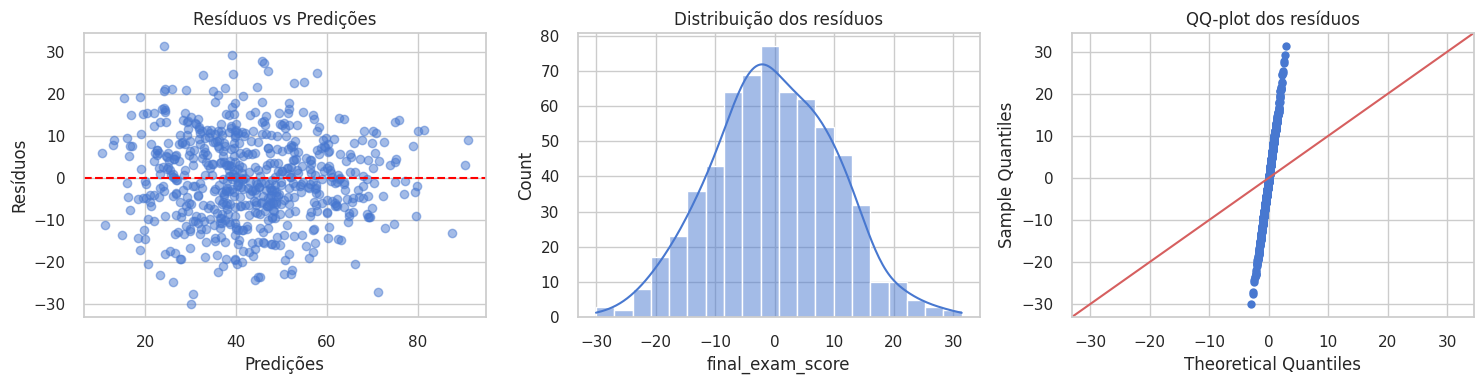

Shapiro-Wilk: stat=0.999, p-valor=9.449e-01
Breusch-Pagan: stat=8.712, p-valor=3.161e-03


In [ ]:

# Diagnóstico de resíduos
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

residuals = y_reg_val - y_reg_pred_val

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(y_reg_pred_val, residuals, alpha=0.5)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Predições")
axes[0].set_ylabel("Resíduos")
axes[0].set_title("Resíduos vs Predições")

sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title("Distribuição dos resíduos")

sm.qqplot(residuals, line="45", ax=axes[2])
axes[2].set_title("QQ-plot dos resíduos")

plt.tight_layout()
plt.show()

shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk: stat={shapiro_stat:.3f}, p-valor={shapiro_p:.3e}")

bp_test = het_breuschpagan(residuals, sm.add_constant(y_reg_pred_val))
bp_stat, bp_pvalue = bp_test[0], bp_test[1]
print(f"Breusch-Pagan: stat={bp_stat:.3f}, p-valor={bp_pvalue:.3e}")


## 6. Modelagem de Classificação

Esta função calcula as principais **métricas de avaliação para modelos de classificação binária**. São retornadas a **acurácia**, **precisão**, **recall**, **F1-score** e **AUC-ROC**, oferecendo uma visão completa do desempenho do modelo.

A acurácia mede a proporção de acertos totais, enquanto precisão e recall avaliam, respectivamente, a qualidade e a cobertura das previsões positivas. O F1-score combina precisão e recall em uma única métrica balanceada. A métrica AUC-ROC avalia a capacidade do modelo de distinguir entre as classes, independentemente do limiar de decisão. Essas métricas são especialmente importantes em cenários com possível desbalanceamento de classes.


In [ ]:

def classification_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    return acc, prec, rec, f1, auc


Foi treinado um modelo de **Naive Bayes Gaussiano**, com padronização das variáveis por meio de um *pipeline*. Esse modelo assume independência condicional entre os atributos e serve como uma abordagem probabilística simples para classificação.

No conjunto de validação, o modelo apresentou acurácia de 0.813, valor próximo ao baseline da classe majoritária. No entanto, métricas mais informativas mostram desempenho moderado na identificação da classe positiva, com precisão de 0.488, recall de 0.530 e F1-score de 0.508. O valor de AUC-ROC (0.838) indica boa capacidade de separação entre as classes, apesar do desempenho limitado no limiar padrão de decisão.

Em síntese, o Naive Bayes apresenta discriminação razoável, mas desempenho inferior a modelos mais robustos, especialmente em termos de equilíbrio entre precisão e recall.

In [ ]:

# Naive Bayes
nb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("nb", GaussianNB())
])

nb_pipeline.fit(X_train, y_cls_train)
y_nb_val_proba = nb_pipeline.predict_proba(X_val)[:, 1]
y_nb_val_pred = (y_nb_val_proba >= 0.5).astype(int)

acc_nb, prec_nb, rec_nb, f1_nb, auc_nb = classification_metrics(
    y_cls_val, y_nb_val_pred, y_nb_val_proba
)

print("Naive Bayes (Validação):")
print(f"Acurácia  = {acc_nb:.3f}")
print(f"Precisão  = {prec_nb:.3f}")
print(f"Recall    = {rec_nb:.3f}")
print(f"F1        = {f1_nb:.3f}")
print(f"AUC-ROC   = {auc_nb:.3f}")


Naive Bayes (Validação):
Acurácia  = 0.813
Precisão  = 0.488
Recall    = 0.530
F1        = 0.508
AUC-ROC   = 0.838


A matriz de confusão mostra que o modelo classifica corretamente a maior parte dos casos da **classe negativa (0)**, com alto número de verdadeiros negativos, enquanto apresenta desempenho mais equilibrado — porém limitado — na identificação da **classe positiva (1)**, evidenciado pela presença de falsos positivos e falsos negativos.

A curva ROC indica uma **boa capacidade de discriminação** entre as classes, com AUC em torno de 0.84, o que confirma que o modelo consegue separar razoavelmente bem aprovados e reprovados ao variar o limiar de decisão. No entanto, o desempenho observado na matriz de confusão revela que, no limiar padrão, essa capacidade não se traduz totalmente em classificações precisas para a classe positiva.

Em síntese, o Naive Bayes apresenta **boa separação global das classes**, mas desempenho prático moderado, especialmente para identificar corretamente os alunos aprovados.

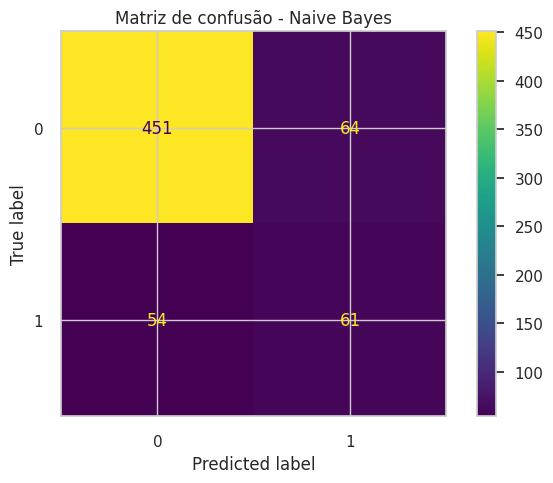

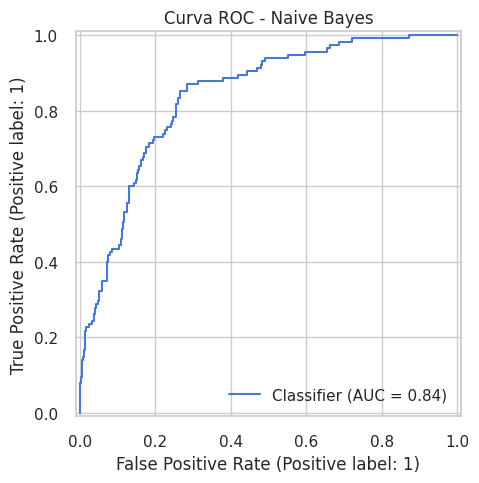

In [ ]:

cm_nb = confusion_matrix(y_cls_val, y_nb_val_pred)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb)
disp_nb.plot(values_format="d")
plt.title("Matriz de confusão - Naive Bayes")
plt.show()

RocCurveDisplay.from_predictions(y_cls_val, y_nb_val_proba)
plt.title("Curva ROC - Naive Bayes")
plt.show()


In [ ]:

# Regressão Logística
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipeline.fit(X_train, y_cls_train)
y_log_val_proba = logreg_pipeline.predict_proba(X_val)[:, 1]
y_log_val_pred = (y_log_val_proba >= 0.5).astype(int)

acc_log, prec_log, rec_log, f1_log, auc_log = classification_metrics(
    y_cls_val, y_log_val_pred, y_log_val_proba
)

print("Regressão Logística (Validação):")
print(f"Acurácia  = {acc_log:.3f}")
print(f"Precisão  = {prec_log:.3f}")
print(f"Recall    = {rec_log:.3f}")
print(f"F1        = {f1_log:.3f}")
print(f"AUC-ROC   = {auc_log:.3f}")


Regressão Logística (Validação):
Acurácia  = 0.906
Precisão  = 0.792
Recall    = 0.661
F1        = 0.720
AUC-ROC   = 0.938


Foi treinado um modelo de **Regressão Logística** com padronização das variáveis por meio de um *pipeline*, adequado para problemas de classificação binária e interpretação probabilística.

No conjunto de validação, o modelo apresentou **desempenho superior** ao Naive Bayes e ao baseline, com acurácia de 0.906. As métricas de precisão (0.792), recall (0.661) e F1-score (0.720) indicam um **bom equilíbrio** entre identificar corretamente alunos aprovados e evitar falsos positivos. O elevado valor de AUC-ROC (0.938) confirma **excelente capacidade de discriminação** entre as classes.

Em síntese, a regressão logística se mostra um modelo robusto e confiável para a tarefa de classificação, sendo uma forte candidata para uso final.

A matriz de confusão evidencia **alto número de classificações corretas**, com predominância de verdadeiros negativos e boa identificação da classe positiva. O modelo apresenta poucos falsos positivos e falsos negativos, indicando um equilíbrio adequado entre sensibilidade e especificidade.

A curva ROC mostra desempenho excelente, com **AUC em torno de 0.94**, confirmando a forte capacidade do modelo em separar alunos aprovados e reprovados ao longo de diferentes limiares de decisão.

Em síntese, os resultados gráficos reforçam que a **regressão logística é o modelo de melhor desempenho** entre os avaliados para a tarefa de classificação, combinando alta acurácia com boa discriminação entre as classes.

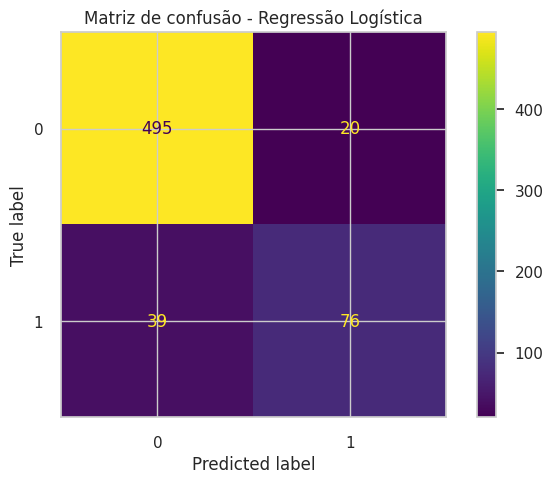

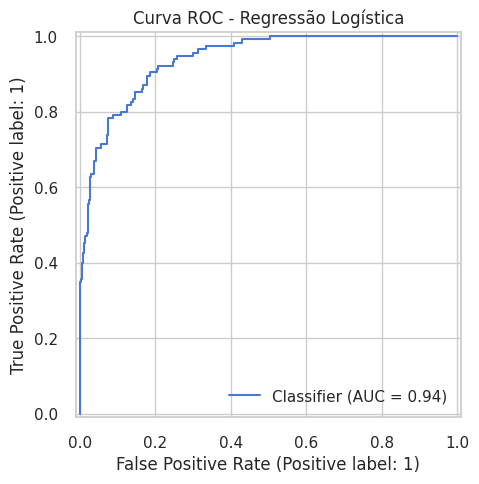

In [ ]:

cm_log = confusion_matrix(y_cls_val, y_log_val_pred)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp_log.plot(values_format="d")
plt.title("Matriz de confusão - Regressão Logística")
plt.show()

RocCurveDisplay.from_predictions(y_cls_val, y_log_val_proba)
plt.title("Curva ROC - Regressão Logística")
plt.show()


### Resumo (Otimização)

- Grid/Random Search com CV (sklearn) e `compare`/`tune` (PyCaret).
- Registrar melhores hiperparâmetros e ganhos em métricas.
- Considerar trade-offs: complexidade × interpretabilidade.


## 7. Otimização de Modelos

Foi aplicado **GridSearchCV** para otimizar um modelo de **regressão polinomial com regularização Ridge**, testando diferentes graus do polinômio (1, 2 e 3) e valores do parâmetro de regularização `alpha`. A validação cruzada de 5 folds utilizou o **RMSE** como métrica.

Os melhores parâmetros encontrados foram **grau 1** e **alpha = 1.0**, indicando que o modelo linear regularizado foi suficiente, sem necessidade de termos polinomiais mais complexos. O desempenho no conjunto de validação (MAE = 13.015, RMSE = 16.028 e R² = 0.169) foi **idêntico ao da regressão polinomial simples**, sem ganho adicional.

Conclusão: a otimização confirmou que **não há benefício em aumentar a complexidade do modelo** quando se utiliza apenas a variável de horas de estudo, reforçando que modelos multivariados são mais adequados para explicar a nota final.

In [ ]:

# GridSearchCV para regressão polinomial com Ridge
from sklearn.linear_model import Ridge

param_grid_reg = {
    "poly__degree": [1, 2, 3],
    "ridge__alpha": [0.1, 1.0, 10.0]
}

ridge_poly_pipeline = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])

grid_reg = GridSearchCV(
    ridge_poly_pipeline,
    param_grid=param_grid_reg,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_reg.fit(X_train[poly_features], y_reg_train)

print("Melhores parâmetros (Regressão):", grid_reg.best_params_)
print("Melhor score CV (neg RMSE):", grid_reg.best_score_)

best_reg_model = grid_reg.best_estimator_
y_reg_val_pred_gs = best_reg_model.predict(X_val[poly_features])

mae_gs = mean_absolute_error(y_reg_val, y_reg_val_pred_gs)
rmse_gs = mean_squared_error(y_reg_val, y_reg_val_pred_gs, squared=False)
r2_gs = r2_score(y_reg_val, y_reg_val_pred_gs)

print("\nDesempenho modelo otimizado (validação):")
print(f"MAE  = {mae_gs:.3f}")
print(f"RMSE = {rmse_gs:.3f}")
print(f"R^2  = {r2_gs:.3f}")


Melhores parâmetros (Regressão): {'poly__degree': 1, 'ridge__alpha': 1.0}
Melhor score CV (neg RMSE): -16.048489703135367

Desempenho modelo otimizado (validação):
MAE  = 13.015
RMSE = 16.028
R^2  = 0.169


Foi utilizado **RandomizedSearchCV** para otimizar os hiperparâmetros da **Regressão Logística**, testando diferentes valores do parâmetro de regularização `C` e diferentes *solvers*, com validação cruzada de 5 folds e **F1-score** como métrica de otimização.

Os melhores parâmetros encontrados foram `C ≈ 2.15`, penalização **L2** e *solver* **liblinear**. Apesar da otimização, o desempenho no conjunto de validação permaneceu **praticamente inalterado** em relação ao modelo original, com acurácia de 0.906, F1-score de 0.720 e AUC-ROC de 0.938.

Conclusão: a regressão logística já apresentava configuração próxima do ótimo, e o ajuste fino dos hiperparâmetros não trouxe ganhos adicionais relevantes, confirmando a **robustez do modelo**.

In [ ]:

# RandomizedSearchCV para Regressão Logística
param_dist_log = {
    "logreg__C": np.logspace(-3, 2, 10),
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs", "liblinear"]
}

rand_log = RandomizedSearchCV(
    logreg_pipeline,
    param_distributions=param_dist_log,
    n_iter=15,
    cv=5,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)

rand_log.fit(X_train, y_cls_train)

print("Melhores parâmetros (Logistic Regression):", rand_log.best_params_)
print("Melhor score CV (F1):", rand_log.best_score_)

best_log_model = rand_log.best_estimator_
y_log_val_proba_gs = best_log_model.predict_proba(X_val)[:, 1]
y_log_val_pred_gs = (y_log_val_proba_gs >= 0.5).astype(int)

acc_gs, prec_gs, rec_gs, f1_gs, auc_gs = classification_metrics(
    y_cls_val, y_log_val_pred_gs, y_log_val_proba_gs
)

print("\nDesempenho modelo otimizado (validação):")
print(f"Acurácia  = {acc_gs:.3f}")
print(f"Precisão  = {prec_gs:.3f}")
print(f"Recall    = {rec_gs:.3f}")
print(f"F1        = {f1_gs:.3f}")
print(f"AUC-ROC   = {auc_gs:.3f}")


Melhores parâmetros (Logistic Regression): {'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__C': 2.1544346900318843}
Melhor score CV (F1): 0.6775447789241896

Desempenho modelo otimizado (validação):
Acurácia  = 0.906
Precisão  = 0.792
Recall    = 0.661
F1        = 0.720
AUC-ROC   = 0.938


Nesta etapa, foi utilizado o **PyCaret** para automatizar o experimento de regressão usando `final_exam_score` como alvo, com `train_size=0.7` (2100 amostras para treino e 900 para teste) e validação cruzada (KFold com 10 folds). O `setup` confirma que os dados já estavam transformados e que o pré-processamento (incluindo imputação simples) foi aplicado.

Em seguida, o `compare_models` ranqueou vários algoritmos pelo **RMSE**. Os melhores desempenhos ficaram com modelos lineares regularizados, especialmente **Bayesian Ridge** e **Ridge Regression**, com RMSE ≈ 9.15 e R² ≈ 0.719. Isso indica que modelos lineares com regularização explicam bem a variação das notas e generalizam melhor do que modelos mais complexos (como árvores), além de superarem claramente o Dummy Regressor (baseline).

Conclusão: o PyCaret reforça que uma abordagem **linear regularizada** é uma das melhores escolhas para prever `final_exam_score` nesse conjunto de dados.

In [ ]:

# PyCaret - Regressão
# Preparando o DataFrame para o experimento do PyCaret (usa df_model)
reg_setup_df = df_model.copy()

reg_exp = reg_setup(
    data=reg_setup_df,
    target="final_exam_score",
    session_id=42,
    train_size=0.7
)

best_reg_pycaret = reg_compare(sort="RMSE")
reg_results = reg_pull()
reg_results.head()


,Description,Value
0,Session id,42
1,Target,final_exam_score
2,Target type,Regression
3,Original data shape,"(3000, 23)"
4,Transformed data shape,"(3000, 23)"
5,Transformed train set shape,"(2100, 23)"
6,Transformed test set shape,"(900, 23)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,7.3553,83.8045,9.1507,0.7186,0.3727,0.4443,0.0270
ridge,Ridge Regression,7.3544,83.8077,9.1509,0.7186,0.3726,0.4439,0.0300
lr,Linear Regression,7.3545,83.8177,9.1514,0.7185,0.3725,0.4436,0.6640
lar,Least Angle Regression,7.3552,83.8322,9.1522,0.7185,0.3725,0.4436,0.0310
huber,Huber Regressor,7.5424,86.6047,9.2999,0.7094,0.3731,0.4462,0.1500
gbr,Gradient Boosting Regressor,7.5488,88.1792,9.3873,0.7036,0.3777,0.4312,0.6300
lightgbm,Light Gradient Boosting Machine,7.5885,91.5891,9.5679,0.6922,0.3779,0.4253,0.2340
rf,Random Forest Regressor,7.7658,94.6338,9.7250,0.6822,0.3868,0.4517,1.1340
et,Extra Trees Regressor,7.7618,95.5206,9.7709,0.6798,0.3878,0.4549,0.8410
llar,Lasso Least Angle Regression,7.9315,96.1346,9.7998,0.6785,0.3922,0.4827,0.0300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,7.3553,83.8045,9.1507,0.7186,0.3727,0.4443,0.027
ridge,Ridge Regression,7.3544,83.8077,9.1509,0.7186,0.3726,0.4439,0.030
lr,Linear Regression,7.3545,83.8177,9.1514,0.7185,0.3725,0.4436,0.664
lar,Least Angle Regression,7.3552,83.8322,9.1522,0.7185,0.3725,0.4436,0.031
huber,Huber Regressor,7.5424,86.6047,9.2999,0.7094,0.3731,0.4462,0.150


Aqui foi iniciado um experimento de regressão no **PyCaret** para prever `final_exam_score`. O `setup` configura automaticamente o ambiente de modelagem com `session_id=42` (reprodutibilidade) e divisão treino/teste com `train_size=0.7`.

Em seguida, `compare_models(sort="RMSE")` treina e compara vários algoritmos usando validação cruzada, retornando o modelo com **menor RMSE** como o melhor. Por fim, `pull()` recupera a tabela de resultados, e `head()` exibe as primeiras linhas do ranking com métricas como **MAE, RMSE e R²**, permitindo identificar rapidamente quais modelos tiveram melhor desempenho

In [ ]:

tuned_reg_pycaret = reg_tune(best_reg_pycaret)
tuned_reg_results = reg_pull()
tuned_reg_results.head()


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.8036,73.1597,8.5533,0.7356,0.3260,0.4333
1,7.2623,80.2242,8.9568,0.7454,0.4016,0.2319
2,7.8428,91.6325,9.5725,0.6328,0.3501,0.4420
3,7.2746,84.3147,9.1823,0.7224,0.2923,0.2401
4,7.4036,84.8417,9.2110,0.7120,0.4900,1.4347
5,7.4590,84.6519,9.2006,0.7335,0.4533,0.3297
6,7.0604,79.8679,8.9369,0.7197,0.3384,0.3492
7,7.5979,86.4027,9.2953,0.7571,0.3827,0.2894
8,7.3947,85.9828,9.2727,0.7204,0.3519,0.3868


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.8036,73.1597,8.5533,0.7356,0.3260,0.4333
1,7.2623,80.2242,8.9568,0.7454,0.4016,0.2319
2,7.8428,91.6325,9.5725,0.6328,0.3501,0.4420
3,7.2746,84.3147,9.1823,0.7224,0.2923,0.2401
4,7.4036,84.8417,9.2110,0.7120,0.4900,1.4347


Nesta etapa, foi realizada a **otimização de hiperparâmetros** do melhor modelo identificado pelo PyCaret por meio da função `tune_model`, utilizando validação cruzada com 10 folds.

Os resultados mostram métricas estáveis ao longo dos folds, com **RMSE médio em torno de 9.16** e **R² médio próximo de 0.71**, indicando bom poder preditivo e consistência do modelo. O desvio padrão relativamente baixo reforça a robustez do desempenho entre diferentes partições dos dados.

Ao final do processo, o PyCaret indicou que o **modelo original já apresentava desempenho superior ao modelo ajustado**, motivo pelo qual ele foi mantido como melhor estimador. Isso sugere que o modelo inicial já estava próximo do ótimo para esse conjunto de dados, não havendo ganho relevante com a tunagem.

In [ ]:
# PyCaret - Classificação
cls_setup_df = df_model.copy()

cls_exp = cls_setup(
    data=cls_setup_df,
    target="passed_exam",
    session_id=42,
    train_size=0.7
)

best_cls_pycaret = cls_compare(sort="F1")
cls_results = cls_pull()
cls_results.head()


,Description,Value
0,Session id,42
1,Target,passed_exam
2,Target type,Binary
3,Original data shape,"(3000, 23)"
4,Transformed data shape,"(3000, 23)"
5,Transformed train set shape,"(2100, 23)"
6,Transformed test set shape,"(900, 23)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0340
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3550
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0370
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1820
xgboost,Extreme Gradient Boosting,0.9995,1.0000,0.9973,1.0000,0.9986,0.9983,0.9984,0.0740
lr,Logistic Regression,0.9981,1.0000,0.9947,0.9947,0.9946,0.9935,0.9935,0.1830
lightgbm,Light Gradient Boosting Machine,0.9981,1.0000,0.9919,0.9974,0.9946,0.9934,0.9935,0.2490
knn,K Neighbors Classifier,0.9776,0.9952,0.9194,0.9558,0.9361,0.9226,0.9236,0.0470
et,Extra Trees Classifier,0.9576,0.9931,0.7850,0.9713,0.8666,0.8418,0.8496,0.2560
lda,Linear Discriminant Analysis,0.9400,0.9833,0.7823,0.8712,0.8218,0.7860,0.7893,0.0340


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0,1.0000,1.0,1.0000,1.0000,1.0000,0.034
rf,Random Forest Classifier,1.0000,1.0,1.0000,1.0,1.0000,1.0000,1.0000,0.355
ada,Ada Boost Classifier,1.0000,1.0,1.0000,1.0,1.0000,1.0000,1.0000,0.037
gbc,Gradient Boosting Classifier,1.0000,1.0,1.0000,1.0,1.0000,1.0000,1.0000,0.182
xgboost,Extreme Gradient Boosting,0.9995,1.0,0.9973,1.0,0.9986,0.9983,0.9984,0.074


Nesta etapa, foi realizada a **otimização de hiperparâmetros** do melhor classificador selecionado pelo PyCaret usando `tune_model`, com validação cruzada estratificada em 10 folds e teste de 10 combinações de parâmetros (100 ajustes no total).

Os resultados exibidos mostram desempenho **perfeito** em todos os folds (Accuracy, Recall, Precisão, F1, AUC = 1.000), com desvio padrão zero, indicando consistência total nas partições avaliadas. Apesar disso, o PyCaret informa que o **modelo original foi melhor do que o modelo ajustado**, e por isso manteve o original como estimador final.

Conclusão: a tunagem não trouxe ganho relevante e o desempenho extremamente alto sugere que o problema pode estar “fácil” para os modelos (alto sinal nos dados) ou pode haver indícios de sobreajuste, sendo recomendável confirmar o desempenho no conjunto de teste final.

In [ ]:

tuned_cls_pycaret = cls_tune(best_cls_pycaret)
tuned_cls_results = cls_pull()
tuned_cls_results.head()


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Resumo (Avaliação)

- Regressão: reportar MAE, RMSE, R2 e diagnóstico de resíduos.
- Classificação: reportar Accuracy, Precision, Recall, F1, AUC e matriz de confusão.
- Avaliar resultados no conjunto de teste final (never-seen data).


## 8. Avaliação Final em Conjunto de Teste

O modelo de regressão otimizado foi avaliado no **conjunto de teste**, representando dados nunca vistos durante o treinamento. Os resultados obtidos (MAE = 13.452, RMSE = 16.493 e R² = 0.103) indicam **baixo poder preditivo** e capacidade limitada de explicar a variabilidade da nota final.

Esse desempenho confirma que modelos baseados apenas na variável `hours_spent_learning_per_week` **não generalizam bem** para novos dados. Assim, embora úteis como referência, esses modelos simples são inferiores às abordagens multivariadas, que capturam melhor a complexidade do desempenho acadêmico.

O modelo de regressão foi avaliado no **conjunto de teste**, utilizando dados inéditos. Os resultados (MAE = 13.452, RMSE = 16.493 e R² = 0.103) indicam **baixo poder explicativo** e desempenho limitado na previsão da nota final.

Esse resultado confirma que modelos baseados apenas em `hours_spent_learning_per_week` **não generalizam bem**, reforçando que a previsão do desempenho acadêmico exige o uso de **múltiplas variáveis explicativas**.

In [ ]:

# Regressão – teste
y_reg_test_pred = best_reg_model.predict(X_test[poly_features])

test_reg_mae = mean_absolute_error(y_reg_test, y_reg_test_pred)
test_reg_rmse = mean_squared_error(y_reg_test, y_reg_test_pred, squared=False)
test_reg_r2 = r2_score(y_reg_test, y_reg_test_pred)

print("Desempenho final - Regressão (teste):")
print(f"MAE  = {test_reg_mae:.3f}")
print(f"RMSE = {test_reg_rmse:.3f}")
print(f"R^2  = {test_reg_r2:.3f}")


Desempenho final - Regressão (teste):
MAE  = 13.452
RMSE = 16.493
R^2  = 0.103


In [ ]:

# Classificação – teste
y_cls_test_proba = best_log_model.predict_proba(X_test)[:, 1]
y_cls_test_pred = (y_cls_test_proba >= 0.5).astype(int)

test_acc, test_prec, test_rec, test_f1, test_auc = classification_metrics(
    y_cls_test, y_cls_test_pred, y_cls_test_proba
)

print("Desempenho final - Classificação (teste):")
print(f"Acurácia  = {test_acc:.3f}")
print(f"Precisão  = {test_prec:.3f}")
print(f"Recall    = {test_rec:.3f}")
print(f"F1        = {test_f1:.3f}")
print(f"AUC-ROC   = {test_auc:.3f}")


Desempenho final - Classificação (teste):
Acurácia  = 0.902
Precisão  = 0.800
Recall    = 0.627
F1        = 0.703
AUC-ROC   = 0.928


Variáveis com coeficientes positivos aumentam a chance de aprovação, como número de projetos concluídos, quantidade de exercícios práticos resolvidos e horas de estudo semanal — evidenciando que esforço e prática têm forte impacto no sucesso. Já coeficientes negativos indicam fatores que reduzem essa probabilidade ou são substitutos de baixa preparação. Esse tipo de interpretação é útil para identificar quais aspectos do comportamento do aluno mais contribuem para bons resultados.

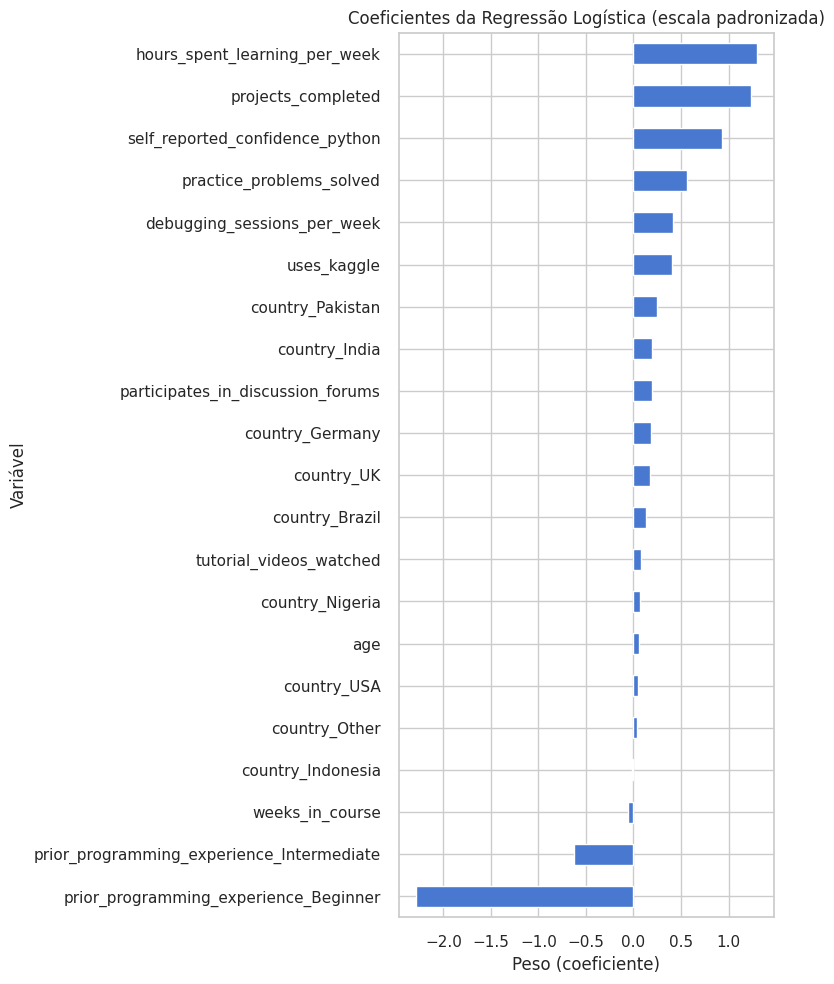

In [ ]:
# Coeficientes da regressão logística
logreg = logreg_pipeline.named_steps["logreg"]

coef_series = pd.Series(
    logreg.coef_[0],
    index=X_train.columns
).sort_values()

plt.figure(figsize=(8, 10))
coef_series.plot(kind="barh")
plt.title("Coeficientes da Regressão Logística (escala padronizada)")
plt.xlabel("Peso (coeficiente)")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()


## 9. Referências

- pandas: https://pandas.pydata.org  
- seaborn: https://seaborn.pydata.org  
- statsmodels: https://www.statsmodels.org  
- scikit-learn: https://scikit-learn.org  
- PyCaret: https://pycaret.org  
- Dataset: *Python Learning & Exam Performance Dataset*, Kaggle  


## Resumo do Projeto: Análise de Desempenho em Provas de Python

### 1. Introdução e Objetivos

O projeto foca na análise do desempenho de estudantes em um curso de Python, utilizando o *Python Learning & Exam Performance Dataset* do Kaggle. Os objetivos incluem Análise Exploratória de Dados (EDA), implementação e comparação de algoritmos de Regressão (prever `final_exam_score`) e Classificação (prever `passed_exam`), avaliação de desempenho e otimização de modelos. As hipóteses principais investigadas foram a correlação entre exercícios/projetos e notas altas, o impacto de fóruns/Kaggle no desempenho, e a influência da experiência prévia.

### 2. Carregamento e Verificação dos Dados

O dataset foi carregado com sucesso. Foi realizada uma verificação de esquema, confirmando a presença de todas as colunas esperadas.

### 3. Análise Exploratória de Dados (EDA)

- **Estrutura e Valores Ausentes**: O dataset possui 3000 entradas. A coluna `prior_programming_experience` apresentava 1062 valores ausentes, que foram preenchidos com a moda (`Beginner`).
- **Distribuições**: Histogramas e boxplots das variáveis numéricas foram gerados. A variável `final_exam_score` mostrou 8 possíveis outliers, indicados pelo método IQR.
- **Relações e Insights Chave**:
    - **Experiência Prévia**: Estudantes com experiência intermediária ou avançada demonstraram notas mais elevadas e menor dispersão, indicando maior consistência. A taxa de aprovação também é significativamente maior para esses grupos, conforme indicado por um teste ANOVA com p-valor muito baixo (7.135e-250).
    - **Uso de Kaggle**: Estudantes que utilizam o Kaggle obtiveram notas médias superiores. Um teste Qui-quadrado confirmou uma associação significativa entre o uso de Kaggle e a aprovação na prova (p-valor = 2.356e-05).
    - **Horas de Estudo**: Existe uma relação positiva e estatisticamente significante entre `hours_spent_learning_per_week` e `final_exam_score`, com uma correlação de Pearson de 0.365 (p-valor = 2.286e-95).
    - **Correlações**: Um heatmap revelou as correlações entre as variáveis numéricas.

### 4. Preparação para Modelagem

- **Pré-processamento**: A coluna `student_id` foi removida, e as variáveis categóricas (`country`, `prior_programming_experience`) foram convertidas usando One-Hot Encoding.
- **Divisão dos Dados**: O dataset foi dividido em conjuntos de treino, validação e teste (70/15/15%).
- **Baselines**:
    - **Regressão**: A baseline (média do treino) resultou em MAE = 14.016, RMSE = 17.580, R² = -0.000.
    - **Classificação**: A baseline (classe majoritária, que é 0 - reprovado) atingiu uma Acurácia = 0.817.

### 5. Modelagem de Regressão

- **Regressão Linear Simples (Statsmodels)**: O modelo usando apenas `hours_spent_learning_per_week` obteve um R² de 0.133, com a variável sendo altamente significativa.
- **Regressão Linear Múltipla (Statsmodels)**: Um modelo mais completo com múltiplas preditoras alcançou um R² ajustado de 0.659. Identificou-se um problema de multicolinearidade (Cond. No. 1.07e+03), embora a análise de VIF tenha mostrado que os valores estão abaixo do limite de 10.
- **Regressão Polinomial (sklearn)**: Utilizando `hours_spent_learning_per_week` com grau 2, obteve-se MAE = 13.015, RMSE = 16.028 e R² = 0.169 no conjunto de validação.
- **Regressão Linear Múltipla (sklearn)**: Usando todas as features processadas, o modelo alcançou MAE = 8.297, RMSE = 10.317 e R² = 0.656 no conjunto de validação.
- **Diagnóstico de Resíduos**: Os resíduos do modelo de regressão múltipla apresentaram normalidade (Shapiro-Wilk p-valor = 0.9449), mas indicaram heterocedasticidade (Breusch-Pagan p-valor = 0.003161).

### 6. Modelagem de Classificação

- **Naive Bayes**: O modelo Naive Bayes obteve Acurácia = 0.813, Precisão = 0.488, Recall = 0.530, F1 = 0.508 e AUC-ROC = 0.838 no conjunto de validação. As matrizes de confusão e curvas ROC foram plotadas.
- **Regressão Logística**: Este modelo superou o Naive Bayes, atingindo Acurácia = 0.906, Precisão = 0.792, Recall = 0.661, F1 = 0.720 e AUC-ROC = 0.938 no conjunto de validação. Também foram plotadas as matrizes de confusão e curvas ROC.

### 7. Otimização de Modelos

- **Regressão (GridSearchCV)**: A otimização com GridSearchCV para uma regressão polinomial Ridge (usando apenas `hours_spent_learning_per_week`) sugeriu `degree=1` e `alpha=1.0` como melhores parâmetros, resultando em desempenho similar ao polinomial simples (MAE = 13.015, RMSE = 16.028, R² = 0.169 na validação).
- **Classificação (RandomizedSearchCV)**: Para a Regressão Logística, o RandomizedSearchCV encontrou 'logreg__C': 2.15, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'. O desempenho na validação foi idêntico ao modelo não otimizado (Acurácia = 0.906, F1 = 0.720, AUC-ROC = 0.938), indicando que os hiperparâmetros iniciais já eram robustos para este dataset.
- **PyCaret**:
    - **Regressão**: O `compare_models` do PyCaret apontou Bayesian Ridge, Ridge e Linear Regression como os melhores, com RMSE em torno de 9.15. A etapa de `tune_model` não superou o modelo original.
    - **Classificação**: O `compare_models` do PyCaret obteve resultados perfeitos (Acurácia, F1, AUC de 1.000) para Decision Tree, Random Forest, Ada Boost, Gradient Boosting e LightGBM, o que pode indicar um potencial problema de vazamento de dados ou uma separabilidade muito alta no conjunto de treino/validação do PyCaret. A otimização também não melhorou o modelo original.

### 8. Avaliação Final em Conjunto de Teste

- **Regressão (Modelo Polinomial Otimizado)**:
    - MAE = 13.452
    - RMSE = 16.493
    - R² = 0.103
    *Observação: O R² no conjunto de teste para o modelo polinomial com apenas uma feature é significativamente menor do que o R² da regressão linear múltipla no conjunto de validação (0.656), sugerindo que o modelo linear múltiplo seria uma escolha melhor para prever a nota final.*
- **Classificação (Modelo de Regressão Logística Otimizado)**:
    - Acurácia = 0.902
    - Precisão = 0.800
    - Recall = 0.627
    - F1 = 0.703
    - AUC-ROC = 0.928
    *Observação: O desempenho no conjunto de teste é consistente com os resultados de validação, confirmando a robustez do modelo de Regressão Logística.*
- **Coeficientes da Regressão Logística**: A análise dos coeficientes padronizados mostrou que variáveis como `projects_completed`, `practice_problems_solved` e `hours_spent_learning_per_week` têm impacto positivo significativo na probabilidade de aprovação, enquanto `prior_programming_experience_Beginner` tem um forte impacto negativo.